In [1]:
from proxy_methods_final import *
import pandas as pd

/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#TODO: MAKE SURE WE ARE COMPARING STANDARDISED TO STANDARDISED
#TODO  FORWARD FILL MISSING DATA
#TODO: CHECK THAT THE CORRECT PARAMS ARE BEING PASSED IN THE PROXY TIMESERIES METHOD AFTER REMOVING THE TICKER

# Load data
---

In [3]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_27980/3926340139.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


# Normal CSRA vs Community CSRA
---

In [4]:
# ticker = "AF" #Defined for the purposes of getting the liquid bucket (EVEN THOUGH WE USE THE INDEX)
# date = '2015-12-30'
# liquid_bucket = get_bucket(metadata, company_communities,ticker)[0]
# metadata_with_proxies = calculate_proxies_and_add_to_metadata(metadata, company_communities, prices_data, index_data, liquid_bucket, date)
# # metadata_with_proxies.to_csv('data/metadata_with_proxies.csv', index=False)

In [5]:
#metadata_with_proxies

In [ ]:
#Get matching dates in price data and index data
#-----------------------------------------
price_dates = prices_data.index.tolist()

#Extract date portion of the datetime object in the price data
index_dates = index_data['Date'].tolist()

matching_dates = [date for date in price_dates if date in index_dates]

In [41]:
tickers = prices_data.columns.to_list()[0:10] #First 10 tickers
dates = matching_dates[0:30] #First 30 dates
liquid_bucket = get_bucket(metadata, company_communities,tickers[0])[0]
proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, liquid_bucket, dates)

/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/

In [67]:
proxy_time_series_df

,Ticker,Date,ActualSpread,ProxyCSRA,ProxyCSRACommunity
0,AAUK,2010-09-14,179.666667,188.974635,127.595482
1,AAUK,2010-09-15,175.666667,188.816959,128.455038
2,AAUK,2010-09-16,174.666667,187.841878,126.074997
3,AAUK,2010-09-17,169.500000,185.686441,125.607317
4,AAUK,2010-09-20,171.833333,185.298821,125.806553
...,...,...,...,...,...
295,AF,2010-10-19,355.303434,138.016285,352.016574
296,AF,2010-10-20,359.310229,138.068778,348.833927
297,AF,2010-10-21,325.739700,134.464077,339.741876
298,AF,2010-10-22,323.543303,135.969851,342.817151


In [75]:
RMSE_csra_normal_list = []
RMSE_csra_communities_list = []

for date in dates:
    #Filter the proxy time series data by the date
    ProxyCSRA_spreads_filtered = proxy_time_series_df[proxy_time_series_df['Date'] == date]

    #Get the actual spreads and the proxy spreads
    actual_spreads = ProxyCSRA_spreads_filtered['ActualSpread']
    proxy_spreads_csra_normal = ProxyCSRA_spreads_filtered['ProxyCSRA']
    proxy_spreads_csra_communities = ProxyCSRA_spreads_filtered['ProxyCSRACommunity']

    #Calculate the RMSE
    RMSE_csra_normal = calculate_rmse(actual_spreads, proxy_spreads_csra_normal)
    RMSE_csra_communities = calculate_rmse(actual_spreads, proxy_spreads_csra_communities)

    RMSE_csra_normal_list.append(RMSE_csra_normal)
    RMSE_csra_communities_list.append(RMSE_csra_communities)


In [77]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

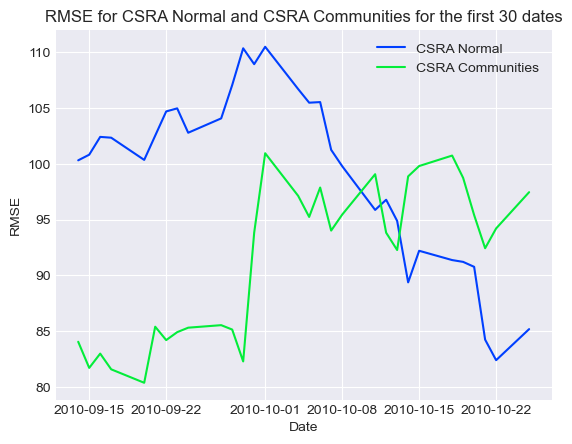

In [79]:
#Plot RMSE for CSRA normal and CSRA communities
plt.plot(dates, RMSE_csra_normal_list, label='CSRA Normal')
plt.plot(dates, RMSE_csra_communities_list, label='CSRA Communities')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title(f'RMSE for CSRA Normal and CSRA Communities for the first {len(dates)} dates')
plt.legend()
